#Supervised Contrastive Learning

[Supervised Contrastive Learning](https://arxiv.org/abs/2004.11362)
(Prannay Khosla et al.) is a training methodology that outperforms
supervised training with crossentropy on classification tasks.

Essentially, training an image classification model with Supervised Contrastive
Learning is performed in two phases:

1. Training an encoder to learn to produce vector representations of input images such
that representations of images in the same class will be more similar compared to
representations of images in different classes.
2. Training a classifier on top of the frozen encoder.

Implementation by G. M. Shahariar Shibli

#Version and GPU check

In [1]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [2]:
!nvidia-smi

Sun Apr 30 13:09:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Installation

In [3]:
%%capture
!pip3 install tensorflow-addons
!pip3 install tf_keras_vis

#Imports

In [4]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow import keras

import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import numpy as np
import cv2
import datetime
import glob
import os

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#Configurations

In [5]:
BATCH_SIZE = 64 
EPOCHS = 50
CROP_TO = 224

num_classes = 23
input_shape = (224, 224, 3)

LR = 2e-5
shuffler = 1024

#Data Augmentation

In [6]:
def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    return image

def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0, 255)
    return x

def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image, label):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image, label

# Data Processing

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
cecum = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/cecum/*.*')
ileum = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ileum/*.*')
retroflex_rectum = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/retroflex_rectum/*.*')
hemorrhoids = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/hemorrhoids/*.*')
polyps = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/polyps/*.*')
ulcerative_colitis_grade_0_1 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-0-1/*.*')
ulcerative_colitis_grade_1 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-1/*.*')
ulcerative_colitis_grade_1_2 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-1-2/*.*')
ulcerative_colitis_grade_2 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-2/*.*')
ulcerative_colitis_grade_2_3 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-2-3/*.*')
ulcerative_colitis_grade_3 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-3/*.*')
bbps_0_1 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/bbps-0-1/*.*')
bbps_2_3 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/bbps-2-3/*.*')
impacted_stool = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/impacted-stool/*.*')
dyed_lifted_polyps = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/dyed-lifted-polyps/*.*')
dyed_resection_margins = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/dyed-resection-margins/*.*')
pylorus = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/pylorus/*.*')
retroflex_stomach = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/retroflex_stomach/*.*')
z_line = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/z_line/*.*')
barretts = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/barretts/*.*')
barretts_short_segment = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/barretts-short-segment/*.*')
esophagitis_a = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/esophagitis-a/*.*')
esophagitis_b_d = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/esophagitis-b-d/*.*')

In [9]:
dataset = {0 :cecum, 1:ileum, 2:retroflex_rectum, 3:hemorrhoids, 4:polyps,5:ulcerative_colitis_grade_0_1,6:ulcerative_colitis_grade_1,7:ulcerative_colitis_grade_1_2,8:ulcerative_colitis_grade_2,9:ulcerative_colitis_grade_2_3,10:ulcerative_colitis_grade_3,11:bbps_0_1 ,12:bbps_2_3,13:impacted_stool,14:dyed_lifted_polyps,15:dyed_resection_margins,16:pylorus,17:retroflex_stomach,18:z_line,19:barretts,20:barretts_short_segment,21:esophagitis_a ,22:esophagitis_b_d }

In [10]:
def combineDataAndLabel(width, height, dataset):
  
  data = []
  labels = []
  count = 0

  for cls in dataset:
      print(f"\n\nconverting {cls} \n\n")
      for i in dataset[cls]:
          print(f"\nconverting image:  {i}")
          image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
          target_size= (width,height))
          image=np.array(image)
          data.append(image)
          count=count+1
          labels.append(cls)
      print(f"\n\processed {count} images \n\n")
      

  # for i in cecum:   
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(0)
  
  # for i in ileum:   
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(1)
  # for i in pylorus:   
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(2)
  # for i in retroflex_rectum:   
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(3)
  # for i in retroflex_stomach:   
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(4)
  # for i in z_line:   
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(5)

  data = np.array(data)
  labels = np.array(labels)

  print(f"\n\nSaving to drive\n\n")
  np.save('/content/drive/MyDrive/ML/combinedData_224', data)
  np.save('/content/drive/MyDrive/ML/combinedLabels_224', labels)
  print(f"\n\nSaved")

  return data, labels


In [11]:
import os
data = []
labels = []
if(os.path.isfile("/content/drive/MyDrive/ML/combinedData_224.npy") and os.path.isfile("/content/drive/MyDrive/ML/combinedLabels_224.npy")):
  data = np.load("/content/drive/MyDrive/ML/combinedData_224.npy")
  labels = np.load("/content/drive/MyDrive/ML/combinedLabels_224.npy")
else:
  data, labels = combineDataAndLabel(224,224,dataset)


In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42,stratify = labels)

In [13]:
# Load data
#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (8529, 224, 224, 3) - y_train shape: (8529,)
x_test shape: (2133, 224, 224, 3) - y_test shape: (2133,)


In [14]:
#contrastive training
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (train_ds.shuffle(shuffler).map(custom_augment).batch(BATCH_SIZE))

#cross-entropy training
train_ds2 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(shuffler).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(shuffler).batch(BATCH_SIZE)

#Contrastive Loss Functions

Max Margin Loss, N pairs loss, Triplet loss, NT-XENT loss

In [15]:
def pdist_euclidean(A):
    # Euclidean pdist
    # https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
    r = tf.reduce_sum(A*A, 1)

    # turn r into column vector
    r = tf.reshape(r, [-1, 1])
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return tf.sqrt(D)


#def square_to_vec(D):
   #'''Convert a squared form pdist matrix to vector form.
    #'''
 #   n = D.shape[0]
  #  triu_idx = np.triu_indices(n, k=1)
   # d_vec = tf.gather_nd(D, list(zip(triu_idx[0], triu_idx[1])))
    #return d_vec
def square_to_vec(D):
    with tf.name_scope("square_to_vec"):
        n = D.shape[0]
        triu_idx = np.triu_indices(n, k=1)
        triu_idx_int = np.array(triu_idx).astype(np.int32)
        d_vec = tf.gather_nd(D, list(zip(triu_idx_int[0], triu_idx_int[1])))
        return d_vec


def get_contrast_batch_labels(y):
    '''
    Make contrast labels by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:   
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    y_col_vec = tf.reshape(tf.cast(y, tf.float32), [-1, 1])
    D_y = pdist_euclidean(y_col_vec)
    d_y = square_to_vec(D_y)
    y_contrasts = tf.cast(d_y == 0, tf.int32)
    return y_contrasts


def get_contrast_batch_labels_regression(y):
    '''
    Make contrast labels for regression by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:   
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    raise NotImplementedError


def max_margin_contrastive_loss(z, y, margin=1.0, metric='euclidean'):
    '''
    Wrapper for the maximum margin contrastive loss (Hadsell et al. 2006)
    `tfa.losses.contrastive_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
        metric: one of ('euclidean', 'cosine')
    '''
    # compute pair-wise distance matrix
    if metric == 'euclidean':
        D = pdist_euclidean(z)
    elif metric == 'cosine':
        D = 1 - tf.matmul(z, z, transpose_a=False, transpose_b=True)
    # convert squareform matrix to vector form
    d_vec = square_to_vec(D)
    # make contrastive labels
    y_contrasts = get_contrast_batch_labels(y)
    loss = tfa.losses.contrastive_loss(y_contrasts, d_vec, margin=margin)
    # exploding/varnishing gradients on large batch?
    return tf.reduce_mean(loss)


def multiclass_npairs_loss(z, y):
    '''
    Wrapper for the multiclass N-pair loss (Sohn 2016)
    `tfa.losses.npairs_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    # cosine similarity matrix
    S = tf.matmul(z, z, transpose_a=False, transpose_b=True)
    loss = tfa.losses.npairs_loss(y, S)
    return loss


def triplet_loss(z, y, margin=1.0, kind='hard'):
    '''
    Wrapper for the triplet losses 
    `tfa.losses.triplet_hard_loss` and `tfa.losses.triplet_semihard_loss`
    Args:
        z: hidden vector of shape [bsz, n_features], assumes it is l2-normalized.
        y: ground truth of shape [bsz].    
    '''
    if kind == 'hard':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=False)
    elif kind == 'soft':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=True)
    elif kind == 'semihard':
        loss = tfa.losses.triplet_semihard_loss(y, z, margin=margin)
    return loss


def supervised_nt_xent_loss(z, y, temperature=0.5, base_temperature=0.07):
    '''
    Supervised normalized temperature-scaled cross entropy loss. 
    A variant of Multi-class N-pair Loss from (Sohn 2016)
    Later used in SimCLR (Chen et al. 2020, Khosla et al. 2020).
    Implementation modified from: 
        - https://github.com/google-research/simclr/blob/master/objective.py
        - https://github.com/HobbitLong/SupContrast/blob/master/losses.py
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    batch_size = tf.shape(z)[0]
    contrast_count = 1
    anchor_count = contrast_count
    y = tf.expand_dims(y, -1)

    # mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
    #     has the same class as sample i. Can be asymmetric.
    mask = tf.cast(tf.equal(y, tf.transpose(y)), tf.float32)
    anchor_dot_contrast = tf.divide(
        tf.matmul(z, tf.transpose(z)),
        temperature
    )
    # # for numerical stability
    logits_max = tf.reduce_max(anchor_dot_contrast, axis=1, keepdims=True)
    logits = anchor_dot_contrast - logits_max
    # # tile mask
    logits_mask = tf.ones_like(mask) - tf.eye(batch_size)
    mask = mask * logits_mask
    # compute log_prob
    exp_logits = tf.exp(logits) * logits_mask
    log_prob = logits - \
        tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))

    # compute mean of log-likelihood over positive
    # this may introduce NaNs due to zero division,
    # when a class only has one example in the batch
    mask_sum = tf.reduce_sum(mask, axis=1)
    mean_log_prob_pos = tf.reduce_sum(
        mask * log_prob, axis=1)[mask_sum > 0] / mask_sum[mask_sum > 0]

    # loss
    loss = -(temperature / base_temperature) * mean_log_prob_pos
    # loss = tf.reduce_mean(tf.reshape(loss, [anchor_count, batch_size]))
    loss = tf.reduce_mean(loss)
    return loss

#Encoder with Contrastive Learning

In [16]:
#Layer Batch Normalization
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''

    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [17]:
# Encoder Architecture
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.Xception(include_top=False, weights=None, input_shape=input_shape)
    base_model.trainable = True
    h = base_model.output
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    normalized_embed = UnitNormLayer()(projection_3)

    resnet_simclr = Model(base_model.inputs, normalized_embed)

    return resnet_simclr

In [18]:
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model = get_resnet_simclr(512, 256, 128)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [20]:
train_loss_cl = tf.keras.metrics.Mean(name='train_loss')
test_loss_cl = tf.keras.metrics.Mean(name='test_loss')

In [21]:
@tf.function

def train_step_contrastive(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = model(x, training=True)
        loss = max_margin_contrastive_loss(r, y, margin=1.0, metric='euclidean')

    gradients = tape.gradient(loss, model.trainable_variables)
    encoder_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss_cl(loss)

In [22]:
@tf.function
def test_step_contrastive(x, y):
    r = model(x, training=False)
    t_loss = max_margin_contrastive_loss(r, y, margin=1.0, metric='euclidean')
    test_loss_cl(t_loss)

In [ ]:
#Encoder training
train_loss_dict = {}
test_loss_dict = {}

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss_cl.reset_states()
    test_loss_cl.reset_states()

    for x, y in tqdm(train_ds):
        train_step_contrastive(x, y)

    for x_te, y_te in test_ds:
        test_step_contrastive(x_te, y_te)

    template = 'Epoch {}, Training Loss: {}, Test Loss: {}'
    print(template.format(epoch + 1,train_loss_cl.result(),test_loss_cl.result()))
    train_loss_dict[epoch] = train_loss_cl.result().numpy()*100
    test_loss_dict[epoch] = test_loss_cl.result().numpy()*100

100%|██████████| 134/134 [03:00<00:00,  1.35s/it]


Epoch 1, Training Loss: 0.07692428678274155, Test Loss: 0.8606560230255127


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 2, Training Loss: 0.05900251865386963, Test Loss: 0.8116286993026733


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 3, Training Loss: 0.05514580383896828, Test Loss: 0.7216553092002869


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 4, Training Loss: 0.052153486758470535, Test Loss: 0.5465297102928162


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 5, Training Loss: 0.05041360855102539, Test Loss: 0.1580970138311386


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 6, Training Loss: 0.04777556657791138, Test Loss: 0.04211517423391342


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 7, Training Loss: 0.045771822333335876, Test Loss: 0.036336757242679596


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 8, Training Loss: 0.04440007358789444, Test Loss: 0.033719487488269806


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 9, Training Loss: 0.043674618005752563, Test Loss: 0.033681731671094894


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 10, Training Loss: 0.041081059724092484, Test Loss: 0.03227105736732483


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 11, Training Loss: 0.040352415293455124, Test Loss: 0.03160462528467178


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 12, Training Loss: 0.038919173181056976, Test Loss: 0.030216610059142113


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 13, Training Loss: 0.0364563874900341, Test Loss: 0.031598687171936035


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 14, Training Loss: 0.03643566370010376, Test Loss: 0.028448980301618576


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 15, Training Loss: 0.035327933728694916, Test Loss: 0.02837143838405609


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 16, Training Loss: 0.034637413918972015, Test Loss: 0.026724552735686302


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 17, Training Loss: 0.033517930656671524, Test Loss: 0.03108748234808445


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 18, Training Loss: 0.03260062634944916, Test Loss: 0.027321545407176018


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 19, Training Loss: 0.03241124376654625, Test Loss: 0.027800779789686203


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 20, Training Loss: 0.03043275512754917, Test Loss: 0.02626926451921463


100%|██████████| 134/134 [02:21<00:00,  1.06s/it]


Epoch 21, Training Loss: 0.030613411217927933, Test Loss: 0.026422468945384026


100%|██████████| 134/134 [02:13<00:00,  1.01it/s]


Epoch 22, Training Loss: 0.029859347268939018, Test Loss: 0.02452169731259346


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 23, Training Loss: 0.029589204117655754, Test Loss: 0.02388143166899681


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 24, Training Loss: 0.02869228832423687, Test Loss: 0.028658337891101837


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 25, Training Loss: 0.02778785675764084, Test Loss: 0.02362639643251896


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 26, Training Loss: 0.027859212830662727, Test Loss: 0.024479128420352936


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 27, Training Loss: 0.028083523735404015, Test Loss: 0.02910693921148777


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 28, Training Loss: 0.026782698929309845, Test Loss: 0.02456728182733059


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 29, Training Loss: 0.02597552165389061, Test Loss: 0.022505847737193108


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 30, Training Loss: 0.02564673312008381, Test Loss: 0.02416108548641205


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 31, Training Loss: 0.02544422075152397, Test Loss: 0.023463424295186996


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 32, Training Loss: 0.02470097690820694, Test Loss: 0.023660171777009964


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 33, Training Loss: 0.024761158972978592, Test Loss: 0.021722689270973206


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 34, Training Loss: 0.023612599819898605, Test Loss: 0.024682901799678802


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 35, Training Loss: 0.023855600506067276, Test Loss: 0.025388095527887344


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 36, Training Loss: 0.023271307349205017, Test Loss: 0.026462610810995102


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 37, Training Loss: 0.02248961478471756, Test Loss: 0.023335864767432213


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 38, Training Loss: 0.021968988701701164, Test Loss: 0.021142447367310524


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 39, Training Loss: 0.021868988871574402, Test Loss: 0.021902883425354958


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 40, Training Loss: 0.021084437146782875, Test Loss: 0.02218041941523552


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 41, Training Loss: 0.021021900698542595, Test Loss: 0.021602071821689606


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 42, Training Loss: 0.020612601190805435, Test Loss: 0.023939630016684532


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 43, Training Loss: 0.019990064203739166, Test Loss: 0.021790245547890663


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 44, Training Loss: 0.020086221396923065, Test Loss: 0.02127990312874317


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 45, Training Loss: 0.019289996474981308, Test Loss: 0.02174273505806923


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 46, Training Loss: 0.01828114315867424, Test Loss: 0.021437689661979675


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 47, Training Loss: 0.01813073642551899, Test Loss: 0.021802052855491638


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 48, Training Loss: 0.01773560233414173, Test Loss: 0.020377691835165024


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 49, Training Loss: 0.017137885093688965, Test Loss: 0.026626287028193474


100%|██████████| 134/134 [02:12<00:00,  1.01it/s]


Epoch 50, Training Loss: 0.017165351659059525, Test Loss: 0.0211370550096035


In [ ]:
from pickle import load, dump
from matplotlib.pylab import plt
from numpy import arange

In [ ]:
# Save the training loss values
with open('/content/drive/MyDrive/ML/train_loss_Xception.pkl', 'wb') as file:
    dump(train_loss_dict, file)

# Save the validation loss values
with open('/content/drive/MyDrive/ML/test_loss_Xception.pkl', 'wb') as file:
    dump(test_loss_dict, file)

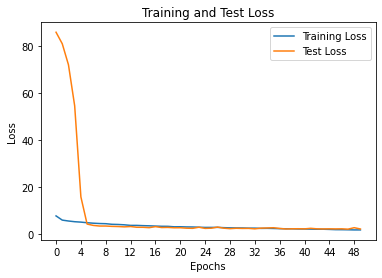

In [ ]:
# Load the training and validation loss dictionaries
train_loss = load(open('/content/drive/MyDrive/ML/train_loss_Xception.pkl', 'rb'))
test_loss = load(open('/content/drive/MyDrive/ML/test_loss_Xception.pkl', 'rb'))

# Retrieve each dictionary's values
train_values = train_loss.values()
test_values = test_loss.values()
 
# Generate a sequence of integers to represent the epoch numbers
epochs = range(50)
 
# Plot and label the training and validation loss values
plt.plot(epochs, np.array(list(train_values)).astype(float), label='Training Loss')
plt.plot(epochs, np.array(list(test_values)).astype(float), label='Test Loss')
 
# Add in a title and axes labels
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 50, 4))
 
# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
#model save
dir = '/content/drive/MyDrive/Colab Notebooks/'
filename =os.path.join( dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "Xception_simclr.h5")  ##set your path then model name: /content/resnet.h5
print(filename)

model.save_weights(filename)

/content/drive/MyDrive/Colab Notebooks/20230311-191027Xception_simclr.h5


#Classifier with frozen Encoder

In [23]:
new_model = get_resnet_simclr(512, 256, 128)
new_model.load_weights("/content/drive/MyDrive/Colab Notebooks/20230311-191027Xception_simclr.h5")

In [24]:
classifier_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

In [25]:
def Classifier_Network():
    '''For stage 2, simply a softmax on top of the Encoder.
    '''
    contrast_model = new_model
    contrast_model.trainable = False
    embedd = contrast_model.output
    features = Dropout(0.5)(embedd)
    features = Dense(64, activation="relu")(features)
    features = Dropout(0.5)(features)
    outputs  = Dense(num_classes, activation="softmax")(features)

    classifier_model = Model(contrast_model.inputs, outputs)

    return classifier_model

In [26]:
classifier = Classifier_Network()

In [ ]:
classifier

In [27]:
classifier.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [28]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [29]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [30]:
sample_weight = tf.random.uniform((tf.shape(y_train)[0], 1),
                                    minval=0,
                                    maxval=1,
                                    dtype=tf.float32)
sample_weight

<tf.Tensor: shape=(8529, 1), dtype=float32, numpy=
array([[0.7861433 ],
       [0.49920297],
       [0.29927063],
       ...,
       [0.05716491],
       [0.14451802],
       [0.6533736 ]], dtype=float32)>

In [31]:
@tf.function
# train step for the 2nd stage
def train_step(x, y,sample_weight):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        y_preds = classifier(x, training=True)
        loss = cce_loss_obj(y, y_preds,sample_weight = sample_weight)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss, 
                              classifier.trainable_variables) 
    classifier_optimizer.apply_gradients(zip(gradients, 
                                  classifier.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [32]:
@tf.function
def test_step(x, y):
    y_preds = classifier(x, training=False)
    t_loss = cce_loss_obj(y, y_preds)
    test_loss(t_loss)
    test_acc(y, y_preds)

In [ ]:
#classifier training
train_loss_dict_classifier = {}
test_loss_dict_classifier = {}
train_acc_dict = {}
test_acc_dict = {}

for epoch in range(220):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()
    

    for x, y in tqdm(train_ds2):
        #print(x.shape,y.shape)
        sample_weight = tf.random.uniform((tf.shape(x)[0], 1),
                                    minval=0,
                                    maxval=1,
                                    dtype=tf.float32)
        train_step(x, y,sample_weight)

    for x_te, y_te in test_ds:
        test_step(x_te, y_te)      
        
    template = 'Epoch {}, Train Loss: {}, Train Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,train_loss.result(), train_acc.result() * 100,test_loss.result(),test_acc.result() * 100))
    train_loss_dict_classifier[epoch] = train_loss.result().numpy()
    test_loss_dict_classifier[epoch] = test_loss.result().numpy()
    train_acc_dict[epoch] = train_acc.result().numpy()*100
    test_acc_dict[epoch] = test_acc.result().numpy()*100

100%|██████████| 134/134 [00:52<00:00,  2.56it/s]


Epoch 1, Train Loss: 1.5671780109405518, Train Acc: 4.971274375915527, Test Loss: 3.1259446144104004, Test Acc: 8.063759803771973


100%|██████████| 134/134 [00:37<00:00,  3.57it/s]


Epoch 2, Train Loss: 1.5572004318237305, Train Acc: 6.436862945556641, Test Loss: 3.10019588470459, Test Acc: 10.829817771911621


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 3, Train Loss: 1.5465017557144165, Train Acc: 8.195568084716797, Test Loss: 3.0728440284729004, Test Acc: 14.252227783203125


100%|██████████| 134/134 [00:37<00:00,  3.54it/s]


Epoch 4, Train Loss: 1.5397671461105347, Train Acc: 10.294289588928223, Test Loss: 3.0451276302337646, Test Acc: 17.158931732177734


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 5, Train Loss: 1.5126299858093262, Train Acc: 12.475085258483887, Test Loss: 3.017357349395752, Test Acc: 26.863571166992188


100%|██████████| 134/134 [00:37<00:00,  3.61it/s]


Epoch 6, Train Loss: 1.5039341449737549, Train Acc: 14.022745132446289, Test Loss: 2.9887943267822266, Test Acc: 33.005157470703125


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 7, Train Loss: 1.487763524055481, Train Acc: 17.340837478637695, Test Loss: 2.956528902053833, Test Acc: 34.59915542602539


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 8, Train Loss: 1.4801687002182007, Train Acc: 19.96717071533203, Test Loss: 2.9274916648864746, Test Acc: 35.06797790527344


100%|██████████| 134/134 [00:37<00:00,  3.61it/s]


Epoch 9, Train Loss: 1.4597748517990112, Train Acc: 22.48798179626465, Test Loss: 2.892251968383789, Test Acc: 46.085323333740234


100%|██████████| 134/134 [00:37<00:00,  3.61it/s]


Epoch 10, Train Loss: 1.46377432346344, Train Acc: 24.78602409362793, Test Loss: 2.859657049179077, Test Acc: 48.570091247558594


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 11, Train Loss: 1.4225549697875977, Train Acc: 27.130964279174805, Test Loss: 2.822180986404419, Test Acc: 52.69573211669922


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 12, Train Loss: 1.422325849533081, Train Acc: 30.33180809020996, Test Loss: 2.784679651260376, Test Acc: 58.32161331176758


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 13, Train Loss: 1.4032785892486572, Train Acc: 31.68014907836914, Test Loss: 2.746065378189087, Test Acc: 60.2437858581543


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 14, Train Loss: 1.3871066570281982, Train Acc: 35.47895431518555, Test Loss: 2.70735502243042, Test Acc: 61.50960922241211


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 15, Train Loss: 1.3719239234924316, Train Acc: 37.53077697753906, Test Loss: 2.662092924118042, Test Acc: 61.88467025756836


100%|██████████| 134/134 [00:37<00:00,  3.57it/s]


Epoch 16, Train Loss: 1.3367419242858887, Train Acc: 39.86399459838867, Test Loss: 2.6226308345794678, Test Acc: 61.97843551635742


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 17, Train Loss: 1.3254822492599487, Train Acc: 41.98616409301758, Test Loss: 2.573875904083252, Test Acc: 62.11907958984375


100%|██████████| 134/134 [00:37<00:00,  3.58it/s]


Epoch 18, Train Loss: 1.301155924797058, Train Acc: 43.686248779296875, Test Loss: 2.5326404571533203, Test Acc: 62.16596221923828


100%|██████████| 134/134 [00:36<00:00,  3.63it/s]


Epoch 19, Train Loss: 1.283833622932434, Train Acc: 46.17188262939453, Test Loss: 2.484161138534546, Test Acc: 62.30661392211914


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 20, Train Loss: 1.2632721662521362, Train Acc: 47.43815231323242, Test Loss: 2.437821865081787, Test Acc: 62.353492736816406


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 21, Train Loss: 1.233418345451355, Train Acc: 49.10306167602539, Test Loss: 2.3912193775177, Test Acc: 62.4472541809082


100%|██████████| 134/134 [00:37<00:00,  3.58it/s]


Epoch 22, Train Loss: 1.2246208190917969, Train Acc: 50.86176300048828, Test Loss: 2.3440518379211426, Test Acc: 62.63478469848633


100%|██████████| 134/134 [00:36<00:00,  3.62it/s]


Epoch 23, Train Loss: 1.2059286832809448, Train Acc: 52.50322341918945, Test Loss: 2.2963192462921143, Test Acc: 64.1819076538086


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 24, Train Loss: 1.1716526746749878, Train Acc: 53.183258056640625, Test Loss: 2.253906488418579, Test Acc: 70.9329605102539


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 25, Train Loss: 1.1587079763412476, Train Acc: 54.3088264465332, Test Loss: 2.2075250148773193, Test Acc: 75.99624633789062


100%|██████████| 134/134 [00:37<00:00,  3.62it/s]


Epoch 26, Train Loss: 1.1197493076324463, Train Acc: 55.92683410644531, Test Loss: 2.1604647636413574, Test Acc: 77.02766418457031


100%|██████████| 134/134 [00:37<00:00,  3.61it/s]


Epoch 27, Train Loss: 1.1233357191085815, Train Acc: 56.72412109375, Test Loss: 2.1131179332733154, Test Acc: 77.54336547851562


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 28, Train Loss: 1.088369369506836, Train Acc: 58.095909118652344, Test Loss: 2.066239356994629, Test Acc: 77.59024810791016


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 29, Train Loss: 1.0729155540466309, Train Acc: 58.92836380004883, Test Loss: 2.0267374515533447, Test Acc: 77.59024810791016


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 30, Train Loss: 1.0519983768463135, Train Acc: 60.06565856933594, Test Loss: 1.9866114854812622, Test Acc: 77.63713073730469


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 31, Train Loss: 1.015981912612915, Train Acc: 60.92156219482422, Test Loss: 1.9367284774780273, Test Acc: 77.87154388427734


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 32, Train Loss: 1.023057460784912, Train Acc: 62.4809455871582, Test Loss: 1.893211841583252, Test Acc: 77.91841888427734


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 33, Train Loss: 0.9939084649085999, Train Acc: 62.49267578125, Test Loss: 1.8524227142333984, Test Acc: 77.9653091430664


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 34, Train Loss: 0.9753751754760742, Train Acc: 63.336849212646484, Test Loss: 1.8084235191345215, Test Acc: 77.91841888427734


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 35, Train Loss: 0.9577725529670715, Train Acc: 64.12240600585938, Test Loss: 1.770430564880371, Test Acc: 78.01219177246094


100%|██████████| 134/134 [00:37<00:00,  3.62it/s]


Epoch 36, Train Loss: 0.9397212266921997, Train Acc: 65.31832885742188, Test Loss: 1.7289859056472778, Test Acc: 78.01219177246094


100%|██████████| 134/134 [00:37<00:00,  3.61it/s]


Epoch 37, Train Loss: 0.9209659099578857, Train Acc: 65.77558898925781, Test Loss: 1.6941823959350586, Test Acc: 78.10595703125


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 38, Train Loss: 0.9084614515304565, Train Acc: 66.09215545654297, Test Loss: 1.664060115814209, Test Acc: 78.05907440185547


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 39, Train Loss: 0.8947085738182068, Train Acc: 67.05358123779297, Test Loss: 1.6222753524780273, Test Acc: 78.01219177246094


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 40, Train Loss: 0.8608154654502869, Train Acc: 67.5929183959961, Test Loss: 1.5917038917541504, Test Acc: 78.15283203125


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 41, Train Loss: 0.8597614169120789, Train Acc: 68.37847137451172, Test Loss: 1.5460871458053589, Test Acc: 78.15283203125


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 42, Train Loss: 0.8401727080345154, Train Acc: 69.49232482910156, Test Loss: 1.5127208232879639, Test Acc: 78.19972229003906


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 43, Train Loss: 0.829669713973999, Train Acc: 69.87923431396484, Test Loss: 1.4815765619277954, Test Acc: 78.19972229003906


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 44, Train Loss: 0.8196723461151123, Train Acc: 70.44202423095703, Test Loss: 1.4513254165649414, Test Acc: 78.24659729003906


100%|██████████| 134/134 [00:37<00:00,  3.61it/s]


Epoch 45, Train Loss: 0.8065329790115356, Train Acc: 69.90267944335938, Test Loss: 1.4229671955108643, Test Acc: 78.29348754882812


100%|██████████| 134/134 [00:37<00:00,  3.62it/s]


Epoch 46, Train Loss: 0.7848086357116699, Train Acc: 70.7116928100586, Test Loss: 1.3936207294464111, Test Acc: 78.34036254882812


100%|██████████| 134/134 [00:37<00:00,  3.62it/s]


Epoch 47, Train Loss: 0.7697436809539795, Train Acc: 71.2041244506836, Test Loss: 1.3590928316116333, Test Acc: 78.29348754882812


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 48, Train Loss: 0.7699560523033142, Train Acc: 71.82553100585938, Test Loss: 1.3295940160751343, Test Acc: 78.29348754882812


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 49, Train Loss: 0.7431721091270447, Train Acc: 72.03658294677734, Test Loss: 1.3029921054840088, Test Acc: 78.29348754882812


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 50, Train Loss: 0.7290315628051758, Train Acc: 72.43521881103516, Test Loss: 1.2816022634506226, Test Acc: 78.29348754882812


100%|██████████| 134/134 [00:37<00:00,  3.61it/s]


Epoch 51, Train Loss: 0.7259534597396851, Train Acc: 72.57591247558594, Test Loss: 1.2487397193908691, Test Acc: 78.24659729003906


100%|██████████| 134/134 [00:37<00:00,  3.62it/s]


Epoch 52, Train Loss: 0.6953909993171692, Train Acc: 72.99800872802734, Test Loss: 1.231135606765747, Test Acc: 78.24659729003906


100%|██████████| 134/134 [00:37<00:00,  3.62it/s]


Epoch 53, Train Loss: 0.6933985948562622, Train Acc: 73.40837097167969, Test Loss: 1.1962213516235352, Test Acc: 78.29348754882812


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 54, Train Loss: 0.6824524998664856, Train Acc: 73.63114166259766, Test Loss: 1.178539514541626, Test Acc: 78.29348754882812


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 55, Train Loss: 0.6761989593505859, Train Acc: 73.7601089477539, Test Loss: 1.1560906171798706, Test Acc: 78.34036254882812


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 56, Train Loss: 0.6723414659500122, Train Acc: 74.34634399414062, Test Loss: 1.1373107433319092, Test Acc: 78.38724517822266


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 57, Train Loss: 0.6541343927383423, Train Acc: 74.61601257324219, Test Loss: 1.116711139678955, Test Acc: 78.43412780761719


100%|██████████| 134/134 [00:37<00:00,  3.58it/s]


Epoch 58, Train Loss: 0.6539399027824402, Train Acc: 74.86223602294922, Test Loss: 1.1039667129516602, Test Acc: 78.48101043701172


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 59, Train Loss: 0.6381579637527466, Train Acc: 75.17880249023438, Test Loss: 1.0648657083511353, Test Acc: 78.57477569580078


100%|██████████| 134/134 [00:37<00:00,  3.57it/s]


Epoch 60, Train Loss: 0.6265842318534851, Train Acc: 75.65951538085938, Test Loss: 1.0542738437652588, Test Acc: 78.71542358398438


100%|██████████| 134/134 [00:36<00:00,  3.62it/s]


Epoch 61, Train Loss: 0.6189238429069519, Train Acc: 75.35467529296875, Test Loss: 1.0394294261932373, Test Acc: 78.9029541015625


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 62, Train Loss: 0.6140310764312744, Train Acc: 75.55398559570312, Test Loss: 1.0116215944290161, Test Acc: 79.13736724853516


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 63, Train Loss: 0.6028145551681519, Train Acc: 75.9174575805664, Test Loss: 0.9900429844856262, Test Acc: 79.13736724853516


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 64, Train Loss: 0.5940974354743958, Train Acc: 75.72986602783203, Test Loss: 0.9821768403053284, Test Acc: 79.32489776611328


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 65, Train Loss: 0.5953861474990845, Train Acc: 75.92918395996094, Test Loss: 0.9661058783531189, Test Acc: 79.74683380126953


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 66, Train Loss: 0.572826087474823, Train Acc: 76.06987762451172, Test Loss: 0.941820502281189, Test Acc: 80.02812957763672


100%|██████████| 134/134 [00:37<00:00,  3.58it/s]


Epoch 67, Train Loss: 0.5634993314743042, Train Acc: 76.21057891845703, Test Loss: 0.9308283925056458, Test Acc: 80.02812957763672


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 68, Train Loss: 0.5726020932197571, Train Acc: 76.56231689453125, Test Loss: 0.9090079665184021, Test Acc: 80.35630798339844


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 69, Train Loss: 0.5589372515678406, Train Acc: 76.66783905029297, Test Loss: 0.9079421758651733, Test Acc: 80.73136138916016


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 70, Train Loss: 0.5443167090415955, Train Acc: 77.1133804321289, Test Loss: 0.8921098113059998, Test Acc: 81.1064224243164


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 71, Train Loss: 0.5386360883712769, Train Acc: 77.1133804321289, Test Loss: 0.8722752928733826, Test Acc: 81.34083557128906


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 72, Train Loss: 0.5343728065490723, Train Acc: 77.1602783203125, Test Loss: 0.8622199892997742, Test Acc: 81.52836608886719


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 73, Train Loss: 0.5303071141242981, Train Acc: 77.74651336669922, Test Loss: 0.8417361378669739, Test Acc: 82.0440673828125


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 74, Train Loss: 0.5230914950370789, Train Acc: 77.86376190185547, Test Loss: 0.8282266855239868, Test Acc: 82.51289367675781


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 75, Train Loss: 0.5234622955322266, Train Acc: 77.82858276367188, Test Loss: 0.8151299953460693, Test Acc: 83.02859497070312


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 76, Train Loss: 0.5168021321296692, Train Acc: 78.03962707519531, Test Loss: 0.8173426985740662, Test Acc: 83.26300811767578


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 77, Train Loss: 0.50092613697052, Train Acc: 78.15687561035156, Test Loss: 0.8002804517745972, Test Acc: 83.68495178222656


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 78, Train Loss: 0.4947756826877594, Train Acc: 78.63758850097656, Test Loss: 0.7874411344528198, Test Acc: 83.77871704101562


100%|██████████| 134/134 [00:37<00:00,  3.61it/s]


Epoch 79, Train Loss: 0.4942913353443146, Train Acc: 78.33274841308594, Test Loss: 0.7843496203422546, Test Acc: 84.01313018798828


100%|██████████| 134/134 [00:37<00:00,  3.62it/s]


Epoch 80, Train Loss: 0.49609848856925964, Train Acc: 78.75483703613281, Test Loss: 0.7677720785140991, Test Acc: 84.15377044677734


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 81, Train Loss: 0.4836965501308441, Train Acc: 78.97760772705078, Test Loss: 0.7479103207588196, Test Acc: 84.29441833496094


100%|██████████| 134/134 [00:37<00:00,  3.57it/s]


Epoch 82, Train Loss: 0.48734357953071594, Train Acc: 79.07140350341797, Test Loss: 0.7559968829154968, Test Acc: 84.43506622314453


100%|██████████| 134/134 [00:36<00:00,  3.64it/s]


Epoch 83, Train Loss: 0.47553783655166626, Train Acc: 79.22382354736328, Test Loss: 0.7426784038543701, Test Acc: 84.5288314819336


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 84, Train Loss: 0.4621083438396454, Train Acc: 79.50521850585938, Test Loss: 0.7261938452720642, Test Acc: 84.62259674072266


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 85, Train Loss: 0.4663163125514984, Train Acc: 79.47004699707031, Test Loss: 0.7285372614860535, Test Acc: 84.76324462890625


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 86, Train Loss: 0.4671158492565155, Train Acc: 80.0445556640625, Test Loss: 0.707786500453949, Test Acc: 84.90389251708984


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 87, Train Loss: 0.4517557621002197, Train Acc: 79.70453643798828, Test Loss: 0.705416202545166, Test Acc: 84.90389251708984


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 88, Train Loss: 0.46064332127571106, Train Acc: 80.05628204345703, Test Loss: 0.701622486114502, Test Acc: 85.04454040527344


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 89, Train Loss: 0.45655643939971924, Train Acc: 80.12662506103516, Test Loss: 0.6793354153633118, Test Acc: 85.09141540527344


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 90, Train Loss: 0.4510270357131958, Train Acc: 80.43146514892578, Test Loss: 0.6777591705322266, Test Acc: 85.23207092285156


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 91, Train Loss: 0.4408929646015167, Train Acc: 80.63079071044922, Test Loss: 0.667462170124054, Test Acc: 85.41959381103516


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 92, Train Loss: 0.4372446537017822, Train Acc: 80.74803161621094, Test Loss: 0.6778968572616577, Test Acc: 85.51335906982422


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 93, Train Loss: 0.43316760659217834, Train Acc: 80.88873291015625, Test Loss: 0.6589112281799316, Test Acc: 85.74777221679688


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 94, Train Loss: 0.4216601252555847, Train Acc: 80.90045166015625, Test Loss: 0.6484549045562744, Test Acc: 85.7946548461914


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 95, Train Loss: 0.42401665449142456, Train Acc: 81.252197265625, Test Loss: 0.6406575441360474, Test Acc: 85.7946548461914


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 96, Train Loss: 0.42192816734313965, Train Acc: 81.17012023925781, Test Loss: 0.6352521181106567, Test Acc: 85.74777221679688


100%|██████████| 134/134 [00:37<00:00,  3.62it/s]


Epoch 97, Train Loss: 0.41263002157211304, Train Acc: 81.18184661865234, Test Loss: 0.6385294198989868, Test Acc: 85.74777221679688


100%|██████████| 134/134 [00:37<00:00,  3.62it/s]


Epoch 98, Train Loss: 0.4057644009590149, Train Acc: 81.252197265625, Test Loss: 0.6225297451019287, Test Acc: 85.88842010498047


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 99, Train Loss: 0.41042184829711914, Train Acc: 81.61566162109375, Test Loss: 0.6192438006401062, Test Acc: 85.935302734375


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 100, Train Loss: 0.4034929573535919, Train Acc: 81.80326080322266, Test Loss: 0.6073758006095886, Test Acc: 85.98218536376953


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 101, Train Loss: 0.4037029445171356, Train Acc: 81.95568084716797, Test Loss: 0.6111730933189392, Test Acc: 85.98218536376953


100%|██████████| 134/134 [00:36<00:00,  3.63it/s]


Epoch 102, Train Loss: 0.39793258905410767, Train Acc: 82.20189666748047, Test Loss: 0.6036109328269958, Test Acc: 86.02906799316406


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 103, Train Loss: 0.391751229763031, Train Acc: 82.11982727050781, Test Loss: 0.5900172591209412, Test Acc: 86.1228256225586


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 104, Train Loss: 0.39808493852615356, Train Acc: 81.99085235595703, Test Loss: 0.5949637293815613, Test Acc: 86.26348114013672


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 105, Train Loss: 0.3902244567871094, Train Acc: 82.29570007324219, Test Loss: 0.58106529712677, Test Acc: 86.35723876953125


100%|██████████| 134/134 [00:37<00:00,  3.61it/s]


Epoch 106, Train Loss: 0.38429415225982666, Train Acc: 82.31914520263672, Test Loss: 0.5806102156639099, Test Acc: 86.45100402832031


100%|██████████| 134/134 [00:36<00:00,  3.62it/s]


Epoch 107, Train Loss: 0.38979285955429077, Train Acc: 82.5067367553711, Test Loss: 0.5758476257324219, Test Acc: 86.5916519165039


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 108, Train Loss: 0.3776276409626007, Train Acc: 82.7412338256836, Test Loss: 0.5731977224349976, Test Acc: 86.68541717529297


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 109, Train Loss: 0.3776068389415741, Train Acc: 82.61226654052734, Test Loss: 0.559491753578186, Test Acc: 86.68541717529297


100%|██████████| 134/134 [00:37<00:00,  3.61it/s]


Epoch 110, Train Loss: 0.3709171712398529, Train Acc: 83.01090240478516, Test Loss: 0.5582129955291748, Test Acc: 86.68541717529297


100%|██████████| 134/134 [00:37<00:00,  3.61it/s]


Epoch 111, Train Loss: 0.37257736921310425, Train Acc: 82.78813171386719, Test Loss: 0.5615643858909607, Test Acc: 86.63854217529297


100%|██████████| 134/134 [00:37<00:00,  3.62it/s]


Epoch 112, Train Loss: 0.3767566978931427, Train Acc: 82.63571166992188, Test Loss: 0.549645721912384, Test Acc: 86.63854217529297


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 113, Train Loss: 0.3601890504360199, Train Acc: 82.36604309082031, Test Loss: 0.5447167158126831, Test Acc: 86.68541717529297


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 114, Train Loss: 0.3625248670578003, Train Acc: 83.01090240478516, Test Loss: 0.5460032224655151, Test Acc: 86.77918243408203


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 115, Train Loss: 0.3707966208457947, Train Acc: 83.06952667236328, Test Loss: 0.5361510515213013, Test Acc: 86.77918243408203


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 116, Train Loss: 0.36534690856933594, Train Acc: 83.23367309570312, Test Loss: 0.526482105255127, Test Acc: 86.77918243408203


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 117, Train Loss: 0.36238765716552734, Train Acc: 83.26884460449219, Test Loss: 0.527874231338501, Test Acc: 86.77918243408203


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 118, Train Loss: 0.3566485047340393, Train Acc: 83.52678680419922, Test Loss: 0.529121458530426, Test Acc: 86.8729476928711


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 119, Train Loss: 0.3533337414264679, Train Acc: 83.29229736328125, Test Loss: 0.5371451377868652, Test Acc: 86.96671295166016


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 120, Train Loss: 0.35718101263046265, Train Acc: 83.6088638305664, Test Loss: 0.5159390568733215, Test Acc: 86.91983032226562


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 121, Train Loss: 0.34810417890548706, Train Acc: 83.63231658935547, Test Loss: 0.5105397701263428, Test Acc: 87.06047821044922


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 122, Train Loss: 0.34248271584510803, Train Acc: 83.28057098388672, Test Loss: 0.5061007142066956, Test Acc: 87.06047821044922


100%|██████████| 134/134 [00:36<00:00,  3.63it/s]


Epoch 123, Train Loss: 0.35049739480018616, Train Acc: 83.3743667602539, Test Loss: 0.517137885093689, Test Acc: 87.01359558105469


100%|██████████| 134/134 [00:37<00:00,  3.62it/s]


Epoch 124, Train Loss: 0.3426252007484436, Train Acc: 83.94888305664062, Test Loss: 0.5022421479225159, Test Acc: 87.01359558105469


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 125, Train Loss: 0.3473733961582184, Train Acc: 83.56196594238281, Test Loss: 0.5055151581764221, Test Acc: 87.01359558105469


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 126, Train Loss: 0.33155664801597595, Train Acc: 83.78473663330078, Test Loss: 0.498974084854126, Test Acc: 87.01359558105469


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 127, Train Loss: 0.3453265130519867, Train Acc: 84.17164611816406, Test Loss: 0.4885932207107544, Test Acc: 87.01359558105469


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 128, Train Loss: 0.3366756737232208, Train Acc: 83.92543029785156, Test Loss: 0.4876827895641327, Test Acc: 87.06047821044922


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 129, Train Loss: 0.34441885352134705, Train Acc: 84.06613159179688, Test Loss: 0.4874650835990906, Test Acc: 87.10736083984375


100%|██████████| 134/134 [00:37<00:00,  3.61it/s]


Epoch 130, Train Loss: 0.32844531536102295, Train Acc: 84.19509887695312, Test Loss: 0.48661574721336365, Test Acc: 87.15424346923828


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 131, Train Loss: 0.33325502276420593, Train Acc: 84.05440521240234, Test Loss: 0.4829986095428467, Test Acc: 87.15424346923828


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 132, Train Loss: 0.32878735661506653, Train Acc: 84.03095245361328, Test Loss: 0.47885602712631226, Test Acc: 87.29489135742188


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 133, Train Loss: 0.3224467635154724, Train Acc: 84.55856323242188, Test Loss: 0.47549793124198914, Test Acc: 87.3417739868164


100%|██████████| 134/134 [00:36<00:00,  3.63it/s]


Epoch 134, Train Loss: 0.3280446231365204, Train Acc: 84.23027038574219, Test Loss: 0.47667431831359863, Test Acc: 87.3886489868164


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 135, Train Loss: 0.3212794363498688, Train Acc: 84.59373474121094, Test Loss: 0.46954235434532166, Test Acc: 87.43553924560547


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 136, Train Loss: 0.31485360860824585, Train Acc: 84.72270965576172, Test Loss: 0.4713040590286255, Test Acc: 87.43553924560547


100%|██████████| 134/134 [00:37<00:00,  3.61it/s]


Epoch 137, Train Loss: 0.32471993565559387, Train Acc: 84.81651306152344, Test Loss: 0.475868284702301, Test Acc: 87.43553924560547


100%|██████████| 134/134 [00:37<00:00,  3.61it/s]


Epoch 138, Train Loss: 0.30693355202674866, Train Acc: 84.9103012084961, Test Loss: 0.4715934693813324, Test Acc: 87.48241424560547


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 139, Train Loss: 0.3212480843067169, Train Acc: 84.8047866821289, Test Loss: 0.456970751285553, Test Acc: 87.52930450439453


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 140, Train Loss: 0.32506296038627625, Train Acc: 84.47649383544922, Test Loss: 0.46656322479248047, Test Acc: 87.81059265136719


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 141, Train Loss: 0.30599942803382874, Train Acc: 84.3709716796875, Test Loss: 0.46006301045417786, Test Acc: 87.85747528076172


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 142, Train Loss: 0.30687767267227173, Train Acc: 84.93376159667969, Test Loss: 0.4567868411540985, Test Acc: 87.85747528076172


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 143, Train Loss: 0.30287766456604004, Train Acc: 84.64064025878906, Test Loss: 0.44798168540000916, Test Acc: 87.85747528076172


100%|██████████| 134/134 [00:37<00:00,  3.58it/s]


Epoch 144, Train Loss: 0.30451324582099915, Train Acc: 84.95720672607422, Test Loss: 0.4559405744075775, Test Acc: 87.90435791015625


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 145, Train Loss: 0.30817505717277527, Train Acc: 85.23860168457031, Test Loss: 0.45185166597366333, Test Acc: 87.95124053955078


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 146, Train Loss: 0.30266258120536804, Train Acc: 85.12135314941406, Test Loss: 0.45486384630203247, Test Acc: 87.95124053955078


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 147, Train Loss: 0.301148921251297, Train Acc: 85.0510025024414, Test Loss: 0.44357702136039734, Test Acc: 87.95124053955078


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 148, Train Loss: 0.3082156479358673, Train Acc: 85.42619323730469, Test Loss: 0.45425090193748474, Test Acc: 88.09188842773438


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 149, Train Loss: 0.2987193465232849, Train Acc: 85.16825103759766, Test Loss: 0.4438309073448181, Test Acc: 88.1387710571289


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 150, Train Loss: 0.3011515438556671, Train Acc: 85.3441162109375, Test Loss: 0.4360308051109314, Test Acc: 88.1387710571289


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 151, Train Loss: 0.30410677194595337, Train Acc: 85.3792953491211, Test Loss: 0.44181063771247864, Test Acc: 88.18565368652344


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 152, Train Loss: 0.2930629551410675, Train Acc: 85.2972183227539, Test Loss: 0.4384348392486572, Test Acc: 88.18565368652344


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 153, Train Loss: 0.2987706661224365, Train Acc: 85.2972183227539, Test Loss: 0.4327326714992523, Test Acc: 88.23253631591797


100%|██████████| 134/134 [00:37<00:00,  3.62it/s]


Epoch 154, Train Loss: 0.2909339368343353, Train Acc: 85.54344177246094, Test Loss: 0.4378573000431061, Test Acc: 88.23253631591797


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 155, Train Loss: 0.29343724250793457, Train Acc: 85.32067108154297, Test Loss: 0.4317930340766907, Test Acc: 88.2794189453125


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 156, Train Loss: 0.2948909401893616, Train Acc: 85.26204681396484, Test Loss: 0.4323255717754364, Test Acc: 88.2794189453125


100%|██████████| 134/134 [00:37<00:00,  3.62it/s]


Epoch 157, Train Loss: 0.29302144050598145, Train Acc: 85.20342254638672, Test Loss: 0.4271846115589142, Test Acc: 88.23253631591797


100%|██████████| 134/134 [00:37<00:00,  3.61it/s]


Epoch 158, Train Loss: 0.2936078608036041, Train Acc: 85.2854995727539, Test Loss: 0.428692489862442, Test Acc: 88.2794189453125


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 159, Train Loss: 0.2894229292869568, Train Acc: 85.48481750488281, Test Loss: 0.4236089885234833, Test Acc: 88.2794189453125


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 160, Train Loss: 0.29735884070396423, Train Acc: 85.46136474609375, Test Loss: 0.42761579155921936, Test Acc: 88.2794189453125


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 161, Train Loss: 0.2897806167602539, Train Acc: 85.39102172851562, Test Loss: 0.4292070269584656, Test Acc: 88.32630157470703


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 162, Train Loss: 0.28273487091064453, Train Acc: 85.66068267822266, Test Loss: 0.4205307066440582, Test Acc: 88.37318420410156


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 163, Train Loss: 0.28570494055747986, Train Acc: 85.46136474609375, Test Loss: 0.41848593950271606, Test Acc: 88.37318420410156


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 164, Train Loss: 0.2910429835319519, Train Acc: 85.49653625488281, Test Loss: 0.4163038730621338, Test Acc: 88.4200668334961


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 165, Train Loss: 0.2764846682548523, Train Acc: 85.80138397216797, Test Loss: 0.41938915848731995, Test Acc: 88.37318420410156


100%|██████████| 134/134 [00:36<00:00,  3.63it/s]


Epoch 166, Train Loss: 0.28890708088874817, Train Acc: 85.73103332519531, Test Loss: 0.41972073912620544, Test Acc: 88.4200668334961


100%|██████████| 134/134 [00:44<00:00,  2.98it/s]


Epoch 167, Train Loss: 0.28311166167259216, Train Acc: 85.42619323730469, Test Loss: 0.4128134846687317, Test Acc: 88.46694946289062


100%|██████████| 134/134 [00:36<00:00,  3.62it/s]


Epoch 168, Train Loss: 0.2780367434024811, Train Acc: 85.68413543701172, Test Loss: 0.4092017710208893, Test Acc: 88.4200668334961


100%|██████████| 134/134 [01:06<00:00,  2.01it/s]


Epoch 169, Train Loss: 0.2696104049682617, Train Acc: 85.70758819580078, Test Loss: 0.41121745109558105, Test Acc: 88.51382446289062


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 170, Train Loss: 0.27353358268737793, Train Acc: 85.76620483398438, Test Loss: 0.4071464240550995, Test Acc: 88.51382446289062


100%|██████████| 134/134 [00:37<00:00,  3.55it/s]


Epoch 171, Train Loss: 0.2743009924888611, Train Acc: 85.60206604003906, Test Loss: 0.40689951181411743, Test Acc: 88.46694946289062


100%|██████████| 134/134 [00:36<00:00,  3.65it/s]


Epoch 172, Train Loss: 0.2782942056655884, Train Acc: 85.76620483398438, Test Loss: 0.4028816223144531, Test Acc: 88.46694946289062


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 173, Train Loss: 0.27968597412109375, Train Acc: 85.66068267822266, Test Loss: 0.40445905923843384, Test Acc: 88.46694946289062


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 174, Train Loss: 0.27701011300086975, Train Acc: 85.94207763671875, Test Loss: 0.4040471613407135, Test Acc: 88.46694946289062


100%|██████████| 134/134 [00:37<00:00,  3.55it/s]


Epoch 175, Train Loss: 0.27402475476264954, Train Acc: 85.82483673095703, Test Loss: 0.39997661113739014, Test Acc: 88.46694946289062


100%|██████████| 134/134 [00:37<00:00,  3.62it/s]


Epoch 176, Train Loss: 0.2695944011211395, Train Acc: 86.1062240600586, Test Loss: 0.4028031826019287, Test Acc: 88.51382446289062


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 177, Train Loss: 0.2782789170742035, Train Acc: 85.96553039550781, Test Loss: 0.40330344438552856, Test Acc: 88.56071472167969


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 178, Train Loss: 0.2729913294315338, Train Acc: 85.68413543701172, Test Loss: 0.3976743817329407, Test Acc: 88.65447998046875


100%|██████████| 134/134 [00:37<00:00,  3.58it/s]


Epoch 179, Train Loss: 0.275667667388916, Train Acc: 86.09449768066406, Test Loss: 0.41260990500450134, Test Acc: 88.65447998046875


100%|██████████| 134/134 [00:36<00:00,  3.62it/s]


Epoch 180, Train Loss: 0.26636606454849243, Train Acc: 86.30554962158203, Test Loss: 0.397378146648407, Test Acc: 88.65447998046875


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 181, Train Loss: 0.2667163908481598, Train Acc: 86.20001983642578, Test Loss: 0.40575504302978516, Test Acc: 88.65447998046875


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 182, Train Loss: 0.2742602527141571, Train Acc: 85.94207763671875, Test Loss: 0.39619192481040955, Test Acc: 88.60759735107422


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 183, Train Loss: 0.2673457860946655, Train Acc: 85.91863250732422, Test Loss: 0.3974456191062927, Test Acc: 88.65447998046875


100%|██████████| 134/134 [00:37<00:00,  3.61it/s]


Epoch 184, Train Loss: 0.2718748450279236, Train Acc: 85.87173461914062, Test Loss: 0.39275166392326355, Test Acc: 88.70136260986328


100%|██████████| 134/134 [00:37<00:00,  3.62it/s]


Epoch 185, Train Loss: 0.2663325071334839, Train Acc: 86.16484832763672, Test Loss: 0.3929607570171356, Test Acc: 88.70136260986328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 186, Train Loss: 0.2661888301372528, Train Acc: 86.73936462402344, Test Loss: 0.40265655517578125, Test Acc: 88.70136260986328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 187, Train Loss: 0.26369690895080566, Train Acc: 86.36416625976562, Test Loss: 0.3918215036392212, Test Acc: 88.70136260986328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 188, Train Loss: 0.25862598419189453, Train Acc: 86.2938232421875, Test Loss: 0.38748493790626526, Test Acc: 88.70136260986328


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 189, Train Loss: 0.26342085003852844, Train Acc: 86.31726837158203, Test Loss: 0.38767823576927185, Test Acc: 88.65447998046875


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 190, Train Loss: 0.25953051447868347, Train Acc: 86.7745361328125, Test Loss: 0.38689249753952026, Test Acc: 88.70136260986328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 191, Train Loss: 0.26177120208740234, Train Acc: 86.56349182128906, Test Loss: 0.387832373380661, Test Acc: 88.65447998046875


100%|██████████| 134/134 [00:37<00:00,  3.61it/s]


Epoch 192, Train Loss: 0.2668452560901642, Train Acc: 86.39933776855469, Test Loss: 0.38963204622268677, Test Acc: 88.70136260986328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 193, Train Loss: 0.2579934000968933, Train Acc: 86.85661315917969, Test Loss: 0.38236716389656067, Test Acc: 88.70136260986328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 194, Train Loss: 0.2605436146259308, Train Acc: 86.42279815673828, Test Loss: 0.38365718722343445, Test Acc: 88.70136260986328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 195, Train Loss: 0.2575286626815796, Train Acc: 86.48141479492188, Test Loss: 0.3865348696708679, Test Acc: 88.65447998046875


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 196, Train Loss: 0.2560102939605713, Train Acc: 86.25865173339844, Test Loss: 0.388963520526886, Test Acc: 88.65447998046875


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 197, Train Loss: 0.2566536068916321, Train Acc: 86.3407211303711, Test Loss: 0.3852803409099579, Test Acc: 88.65447998046875


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 198, Train Loss: 0.2620004415512085, Train Acc: 86.50486755371094, Test Loss: 0.3844456374645233, Test Acc: 88.65447998046875


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 199, Train Loss: 0.25333866477012634, Train Acc: 86.50486755371094, Test Loss: 0.37970131635665894, Test Acc: 88.65447998046875


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 200, Train Loss: 0.2577765882015228, Train Acc: 86.96212768554688, Test Loss: 0.3872431218624115, Test Acc: 88.65447998046875


100%|██████████| 134/134 [00:37<00:00,  3.61it/s]


Epoch 201, Train Loss: 0.25247323513031006, Train Acc: 86.79798126220703, Test Loss: 0.38250356912612915, Test Acc: 88.65447998046875


100%|██████████| 134/134 [00:36<00:00,  3.63it/s]


Epoch 202, Train Loss: 0.2497163712978363, Train Acc: 86.69245910644531, Test Loss: 0.3791511058807373, Test Acc: 88.70136260986328


100%|██████████| 134/134 [00:37<00:00,  3.61it/s]


Epoch 203, Train Loss: 0.2541870176792145, Train Acc: 86.84487915039062, Test Loss: 0.37760046124458313, Test Acc: 88.70136260986328


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 204, Train Loss: 0.25753253698349, Train Acc: 86.42279815673828, Test Loss: 0.37977269291877747, Test Acc: 88.70136260986328


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 205, Train Loss: 0.24788916110992432, Train Acc: 86.8214340209961, Test Loss: 0.38145768642425537, Test Acc: 88.70136260986328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 206, Train Loss: 0.25282755494117737, Train Acc: 86.50486755371094, Test Loss: 0.38886046409606934, Test Acc: 88.70136260986328


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 207, Train Loss: 0.2550349831581116, Train Acc: 86.30554962158203, Test Loss: 0.3763907551765442, Test Acc: 88.74823760986328


100%|██████████| 134/134 [00:36<00:00,  3.63it/s]


Epoch 208, Train Loss: 0.24170978367328644, Train Acc: 87.14972686767578, Test Loss: 0.3746446669101715, Test Acc: 88.74823760986328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 209, Train Loss: 0.2522369921207428, Train Acc: 86.85661315917969, Test Loss: 0.3813079595565796, Test Acc: 88.74823760986328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 210, Train Loss: 0.2460993230342865, Train Acc: 86.89178466796875, Test Loss: 0.3691171407699585, Test Acc: 88.74823760986328


100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


Epoch 211, Train Loss: 0.24630634486675262, Train Acc: 86.7862548828125, Test Loss: 0.37601903080940247, Test Acc: 88.74823760986328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 212, Train Loss: 0.251779168844223, Train Acc: 86.5400390625, Test Loss: 0.36921170353889465, Test Acc: 88.74823760986328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 213, Train Loss: 0.24185115098953247, Train Acc: 87.2669677734375, Test Loss: 0.3729894459247589, Test Acc: 88.74823760986328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 214, Train Loss: 0.24368208646774292, Train Acc: 86.79798126220703, Test Loss: 0.37743932008743286, Test Acc: 88.74823760986328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 215, Train Loss: 0.2477075159549713, Train Acc: 86.86833190917969, Test Loss: 0.36810946464538574, Test Acc: 88.74823760986328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 216, Train Loss: 0.2444409877061844, Train Acc: 86.39933776855469, Test Loss: 0.3760718107223511, Test Acc: 88.74823760986328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 217, Train Loss: 0.250088095664978, Train Acc: 86.86833190917969, Test Loss: 0.3698864281177521, Test Acc: 88.74823760986328


100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


Epoch 218, Train Loss: 0.24380840361118317, Train Acc: 86.75108337402344, Test Loss: 0.37235701084136963, Test Acc: 88.74823760986328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 219, Train Loss: 0.24532674252986908, Train Acc: 86.56349182128906, Test Loss: 0.3664906919002533, Test Acc: 88.74823760986328


100%|██████████| 134/134 [00:40<00:00,  3.27it/s]


Epoch 220, Train Loss: 0.25228673219680786, Train Acc: 87.020751953125, Test Loss: 0.3662927746772766, Test Acc: 88.74823760986328


In [ ]:

# Save the training loss values
with open('/content/drive/MyDrive/ML/train_loss_2_Xception.pkl', 'wb') as file:
    dump(train_loss_dict_classifier, file)

# Save the test loss values
with open('/content/drive/MyDrive/ML/test_loss_2_Xception.pkl', 'wb') as file:
    dump(test_loss_dict_classifier, file)

# Save the training acc values
with open('/content/drive/MyDrive/ML/train_acc_2_Xception.pkl', 'wb') as file:
    dump(train_acc_dict, file)

# Save the test acc values
with open('/content/drive/MyDrive/ML/test_acc_2_Xception.pkl', 'wb') as file:
    dump(test_acc_dict, file)

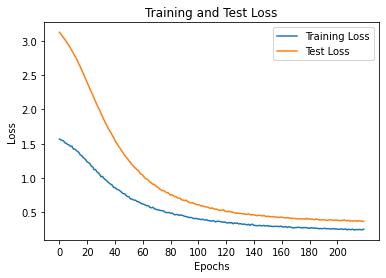

In [ ]:
# Load the training and validation loss dictionaries
train_loss_class = load(open('/content/drive/MyDrive/ML/train_loss_2_Xception.pkl', 'rb'))
test_loss_class = load(open('/content/drive/MyDrive/ML/test_loss_2_Xception.pkl', 'rb'))

# Retrieve each dictionary's values
train_values_class = train_loss_class.values()
test_values_class = test_loss_class.values()
 
# Generate a sequence of integers to represent the epoch numbers
epochs = range(220)
 
# Plot and label the training and validation loss values
plt.plot(epochs, np.array(list(train_values_class)).astype(float), label='Training Loss')
plt.plot(epochs, np.array(list(test_values_class)).astype(float), label='Test Loss')
 
# Add in a title and axes labels
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 220, 20))
 
# Display the plot
plt.legend(loc='best')
plt.show()

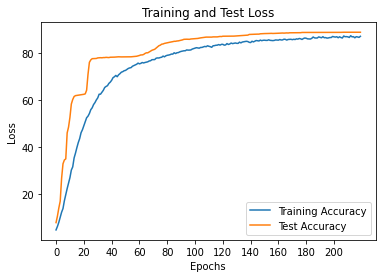

In [ ]:
# Load the training and validation loss dictionaries
train_acc = load(open('/content/drive/MyDrive/ML/train_acc_2_Xception.pkl', 'rb'))
test_acc = load(open('/content/drive/MyDrive/ML/test_acc_2_Xception.pkl', 'rb'))

# Retrieve each dictionary's values
train_values = train_acc.values()
test_values = test_acc.values()
 
# Generate a sequence of integers to represent the epoch numbers
epochs = range(220)
 
# Plot and label the training and validation loss values
plt.plot(epochs, np.array(list(train_values)).astype(float), label='Training Accuracy')
plt.plot(epochs, np.array(list(test_values)).astype(float), label='Test Accuracy')
 
# Add in a title and axes labels
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 220, 20))
 
# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
#model save
dir = '/content/drive/MyDrive/Colab Notebooks/'
filenames =os.path.join( dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "Xception_accuracy_simclr.h5")  ##set your path then model name: /content/resnet.h5
print(filenames)

classifier.save_weights(filenames)

/content/drive/MyDrive/Colab Notebooks/20230320-053059Xception_accuracy_simclr.h5


##Prediction

In [33]:
classifier.load_weights("/content/drive/MyDrive/Colab Notebooks/20230320-053059Xception_accuracy_simclr.h5")

In [64]:
m=745
X = tf.reshape(x_test[m], [1, 224, 224, 3]) ##need to reshape
#classifier.predict(X)
y_test[m]

21

In [65]:
y_predict1 = np.argmax(classifier.predict(X), axis=-1)
y_predict1[0]

1/1 [==============================] - 0s 25ms/step


18

In [ ]:
y_predict = np.argmax(classifier.predict(X), axis=-1)
y_predict

1/1 [==============================] - 0s 34ms/step


array([2])

# Confusion Matrix

In [ ]:
#CONFUSIN MATRIX
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

In [ ]:
class_names = ["cecum", "ileum", "retroflex_rectum", "hemorrhoids", "polyps","ulcerative_colitis_grade_0_1","ulcerative_colitis_grade_1","ulcerative_colitis_grade_1_2","ulcerative_colitis_grade_2","ulcerative_colitis_grade_2_3","ulcerative_colitis_grade_3","bbps_0_1" ,"bbps_2_3","impacted_stool","dyed_lifted_polyps","dyed_resection_margins","pylorus","retroflex_stomach","z_line","barretts","barretts_short_segment","esophagitis_a" ,"esophagitis_b_d"]
print(metrics.classification_report(y_test, y_predict, target_names=class_names))

                              precision    recall  f1-score   support

                       cecum       0.95      1.00      0.97       202
                       ileum       0.00      0.00      0.00         2
            retroflex_rectum       0.91      0.99      0.94        78
                 hemorrhoids       0.00      0.00      0.00         1
                      polyps       0.99      1.00      0.99       206
ulcerative_colitis_grade_0_1       0.00      0.00      0.00         7
  ulcerative_colitis_grade_1       0.00      0.00      0.00        40
ulcerative_colitis_grade_1_2       0.00      0.00      0.00         2
  ulcerative_colitis_grade_2       0.56      0.94      0.70        89
ulcerative_colitis_grade_2_3       0.00      0.00      0.00         5
  ulcerative_colitis_grade_3       0.00      0.00      0.00        27
                    bbps_0_1       0.96      0.98      0.97       129
                    bbps_2_3       1.00      1.00      1.00       230
              impac

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


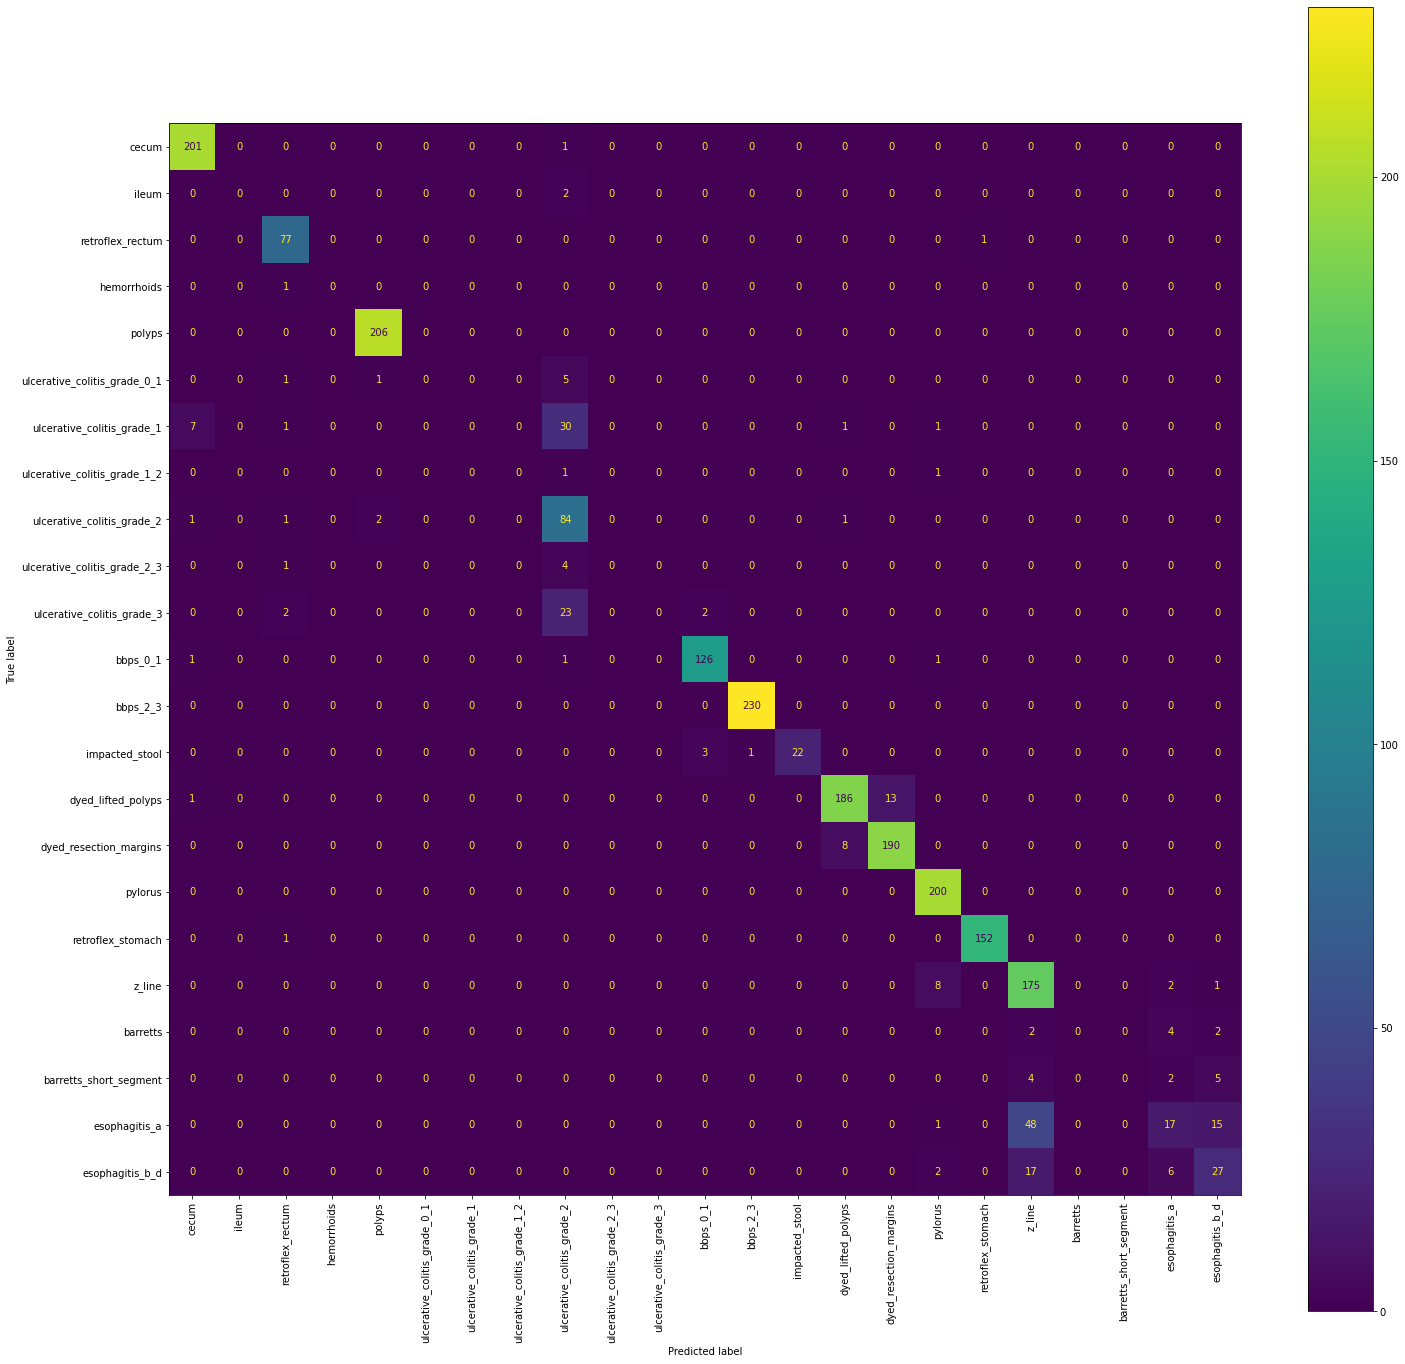

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, y_predict)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = class_names)

plt.rcParams["figure.figsize"] = [24,24]
cm_display.plot(xticks_rotation = 'vertical')
plt.show()

In [66]:
#check layers trainable
for i, layer in enumerate(classifier.layers):
    print(i, layer.name, layer.output_shape, layer.trainable)

0 input_2 [(None, 224, 224, 3)] False
1 block1_conv1 (None, 111, 111, 32) False
2 block1_conv1_bn (None, 111, 111, 32) False
3 block1_conv1_act (None, 111, 111, 32) False
4 block1_conv2 (None, 109, 109, 64) False
5 block1_conv2_bn (None, 109, 109, 64) False
6 block1_conv2_act (None, 109, 109, 64) False
7 block2_sepconv1 (None, 109, 109, 128) False
8 block2_sepconv1_bn (None, 109, 109, 128) False
9 block2_sepconv2_act (None, 109, 109, 128) False
10 block2_sepconv2 (None, 109, 109, 128) False
11 block2_sepconv2_bn (None, 109, 109, 128) False
12 conv2d_4 (None, 55, 55, 128) False
13 block2_pool (None, 55, 55, 128) False
14 batch_normalization_4 (None, 55, 55, 128) False
15 add_12 (None, 55, 55, 128) False
16 block3_sepconv1_act (None, 55, 55, 128) False
17 block3_sepconv1 (None, 55, 55, 256) False
18 block3_sepconv1_bn (None, 55, 55, 256) False
19 block3_sepconv2_act (None, 55, 55, 256) False
20 block3_sepconv2 (None, 55, 55, 256) False
21 block3_sepconv2_bn (None, 55, 55, 256) False
22 c

#XAI

In [67]:
##check if any error occurs here, if occurs, most likely graph not connected
def flatten_model(model):
    if not any(hasattr(layer, 'layers') for layer in model.layers):
        return model  # No sub-model defined within this model
    inputs = None
    outputs = None
    for layer in model.layers:
        if inputs is None:
            inputs = layer.input
        if hasattr(layer, 'layers'):
            submodel = layer
            last_layer = submodel.layers[-1]
            outputs = submodel.output
        
        if outputs is None:
            outputs = layer
        else:
            outputs = layer(outputs)
    return keras.Model(inputs=inputs, outputs=outputs)

flat_model = flatten_model(classifier)

In [68]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

replace2linear = ReplaceToLinear()
X = tf.convert_to_tensor(x_test[745], dtype=tf.float32)    ##need to convert the input data to tensor
y = y_test[745].item()   ##just a single integer value, no numpy array
score = CategoricalScore(y)

In [69]:
image_titles = ['Image']
from matplotlib import cm

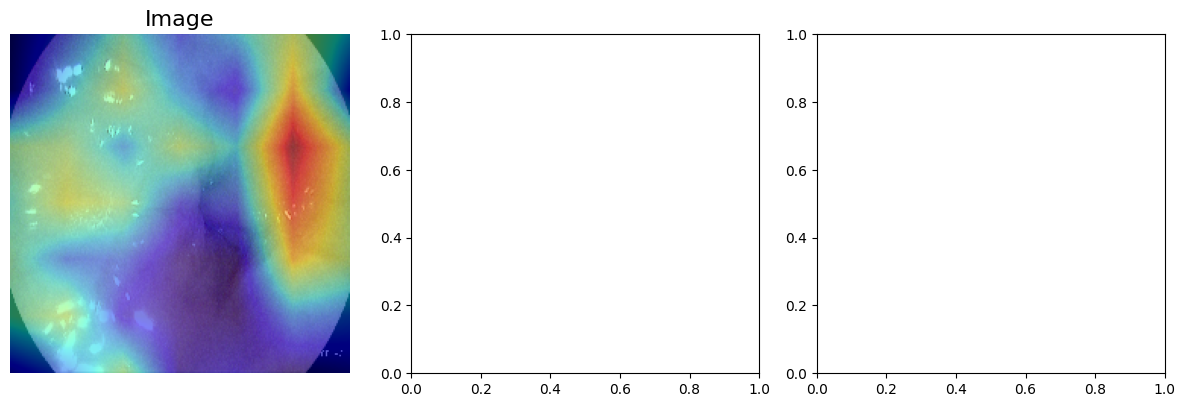

In [70]:
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(classifier,
                  model_modifier=replace2linear,
                  clone=False)

grad_cam = gradcam(score, X, penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap1 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[745])
    ax[i].imshow(heatmap1, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

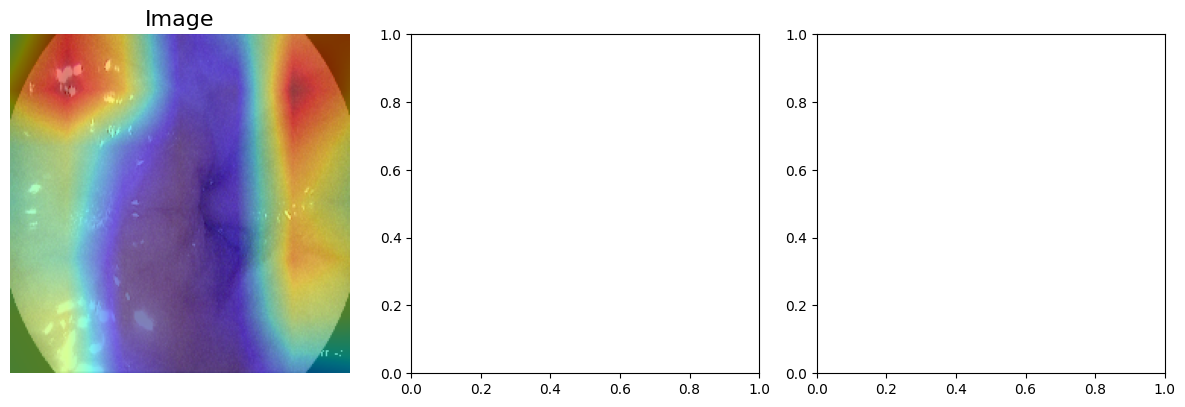

In [71]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Create GradCAM++ object
gradcam = GradcamPlusPlus(classifier, model_modifier=replace2linear,clone=False)

# Generate heatmap with GradCAM++
grad_cam = gradcam(score, X, penultimate_layer=-1)
# Render
#for i, title in enumerate(image_titles):
#    heatmap2 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap2 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[745])
    ax[i].imshow(heatmap2, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 39ms/step


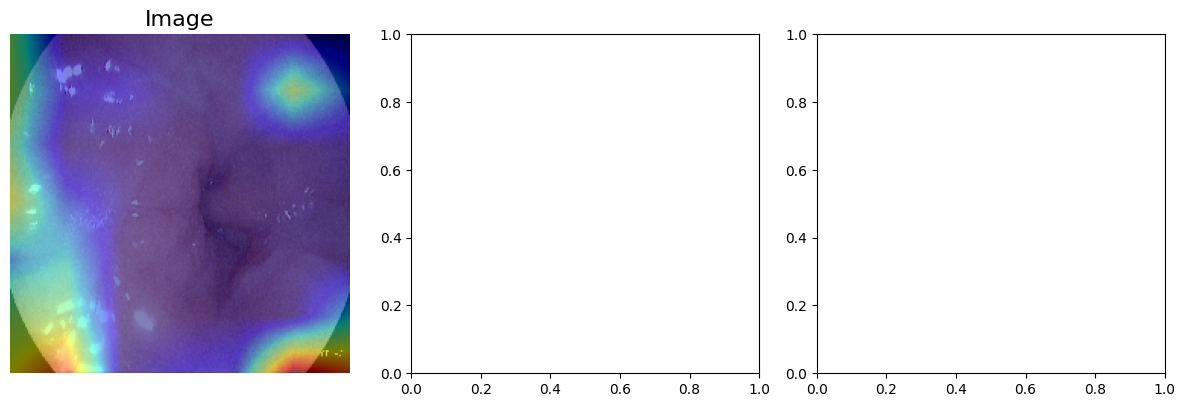

In [72]:
from tf_keras_vis.scorecam import Scorecam
# Create ScoreCAM object
scorecam = Scorecam(classifier)

# Generate heatmap with Faster-ScoreCAM
grad_cam = scorecam(score,X,penultimate_layer=-1,max_N=10)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap4 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[745])
    ax[i].imshow(heatmap4, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

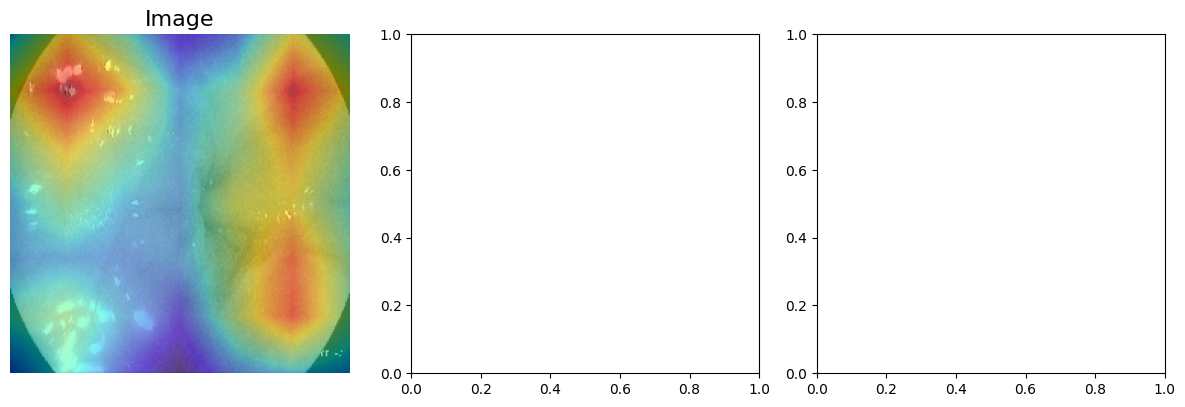

In [73]:
from tf_keras_vis.layercam import Layercam

layercam = Layercam(classifier, model_modifier=replace2linear,clone = False)

# Generate heatmap with Faster-ScoreCAM
grad_cam = layercam(score,X,penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap5 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[745])
    ax[i].imshow(heatmap5, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

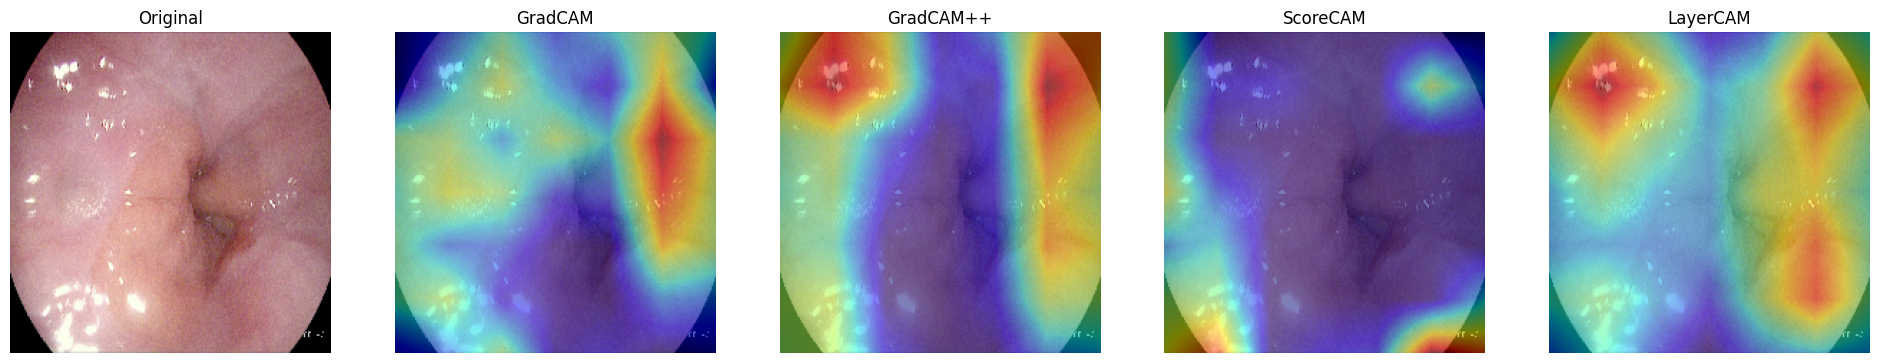

In [74]:
# Render
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(24, 12))

ax[0].set_title("Original", fontsize=12)
ax[0].imshow(x_test[745])
ax[0].axis('off')

ax[1].set_title("GradCAM", fontsize=12)
ax[1].imshow(x_test[745])
ax[1].imshow(heatmap1, cmap='jet', alpha=0.5)
ax[1].axis('off')

ax[2].set_title("GradCAM++", fontsize=12)
ax[2].imshow(x_test[745])
ax[2].imshow(heatmap2, cmap='jet', alpha=0.5)
ax[2].axis('off')

ax[3].set_title("ScoreCAM", fontsize=12)
ax[3].imshow(x_test[745])
ax[3].imshow(heatmap4, cmap='jet', alpha=0.5)
ax[3].axis('off')

ax[4].set_title("LayerCAM", fontsize=12)
ax[4].imshow(x_test[745])
ax[4].imshow(heatmap5, cmap='jet', alpha=0.5)
ax[4].axis('off')

plt.show()